In [1]:
%matplotlib inline
import numpy as np
import subprocess
import matplotlib.pyplot as plt

In [2]:
def get_SNR(file):
    with open(file, "rt")as f:
        a = f.readlines()
    lst = []
    for x in a:
        if "Value:" in x:
            lst.append(float(x.split("Value: ")[1]))
        #print(x.split("bla"))
    lst = lst[len(lst)//2 : ]
    return (np.array(lst).mean(), np.array(lst).std())

In [3]:
def step1(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    rcv = np.frombuffer(_, dtype = np.uint8)
    match = np.array([0, 0, 178, 62, 71, 168, 187, 253, 16, 38, 149, 55, 226, 170, 26], dtype = np.uint8)
    match_extended = np.tile(match, int(rcv.shape[0]/len(match)))
    
    idx = np.argmax([np.mean(np.equal(np.packbits(np.roll(np.unpackbits(rcv), i)), match_extended)) for i in range(15 * 8)])
    
    to_write = np.packbits(np.roll(np.unpackbits(rcv), 9))
    
    with open("output2.data", "wb") as f:
        f.write(to_write)

In [4]:
def step2():
    process=subprocess.Popen(["python2", "BCH_Recoder.py"],
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE,
                             stderr=subprocess.PIPE)


    #time.sleep(10)

    # while os.stat("output.data").st_size < os.stat("orig_pinguim.bmp").st_size * 2:
    #     pass

    inputdata= b" "
    stdoutdata,stderrdata=process.communicate(input=inputdata)
    
    return

In [9]:
def step3(file):
    with open(file, "rb")as f:
        _ = f.read()
    
    final = np.frombuffer(_, dtype = np.uint8)
    
    tx = np.array([0, 255, 40, 250, 37, 42, 186], dtype = np.uint8)
    match_extended_final = np.tile(tx, int(final.shape[0]/len(tx)))
    
    return (1 - np.mean(np.equal(np.unpackbits(final), np.unpackbits(match_extended_final))))

In [119]:
%%time
step1("output.data")

CPU times: user 2.69 s, sys: 2.11 s, total: 4.8 s
Wall time: 4.8 s


In [120]:
%%time
step2()

CPU times: user 4.46 ms, sys: 6.5 ms, total: 11 ms
Wall time: 22.3 s


In [121]:
%%time
step3("output3.data")

CPU times: user 33.5 ms, sys: 20.8 ms, total: 54.3 ms
Wall time: 56.4 ms


0.20281392857142855

In [122]:
get_SNR("output.txt"), step3("output3.data")

((2.340497537313433, 0.4617149626210031), 0.20281392857142855)

## <font color = red> Quanto mais baixo o SNR, maior a chance de ocorrer problemas na recepção, mais chance do resultado obtido ser ruim
    
# <font color = blue> Resultados obtidos simulados
  <font color = blue> SNR Média, SNR STD, BER

      
((7.521259925373134, 0.2656860816505641), 8.571428571468864e-06)
      
((4.803392910447761, 0.3072832420617452), 0.001929196428571478)
      
((4.8254906716417905, 0.29730412967897996), 0.0018147321428571006)
      
((4.061721791044776, 0.3445016723111085), 0.005451517857142818)
      
((3.4622923880597014, 0.3604300021102056), 0.012222767857142824)
      
((2.6754050746268656, 0.44970420913424203), 0.02639437499999997)

In [141]:
a = """
((7.521259925373134, 0.2656860816505641), 8.571428571468864e-06)

((4.803392910447761, 0.3072832420617452), 0.001929196428571478)

((4.8254906716417905, 0.29730412967897996), 0.0018147321428571006)

((4.061721791044776, 0.3445016723111085), 0.005451517857142818)

((3.4622923880597014, 0.3604300021102056), 0.012222767857142824)

((2.6754050746268656, 0.44970420913424203), 0.02639437499999997)
"""

In [142]:
snr_avgs = []
snr_stds = []
bers = []

for line in a.splitlines():
    aux = line.replace("(", "").replace(")", "").split(",")
    if aux != [""]:
        snr_avgs.append(float(aux[0]))
        snr_stds.append(float(aux[1]))
        bers.append(float(aux[2]))

In [143]:
import math

In [144]:
10*math.log10(15/7)

3.3099321904142442

In [145]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)

In [146]:
simu = np.load("ber_simu.npy")

In [147]:
theory = np.load("ber_theory.npy")

In [148]:
theory

array([1.44927687e-01, 1.06228588e-01, 7.21988374e-02, 4.47099721e-02,
       2.46890952e-02, 1.18368372e-02, 4.76517370e-03, 1.54415558e-03,
       3.81742657e-04, 6.72521953e-05, 7.74418644e-06])

In [149]:
simu

array([3.29221926e-01, 2.76622360e-01, 2.16220862e-01, 1.52144629e-01,
       9.42288978e-02, 4.92150989e-02, 2.08547995e-02, 6.86993316e-03,
       1.67249996e-03, 2.74699992e-04, 2.49999991e-05])

In [150]:
np.array(snr_avgs) + 10*math.log10(15/7)

array([10.83119212,  8.1133251 ,  8.13542286,  7.37165398,  6.77222458,
        5.98533727])

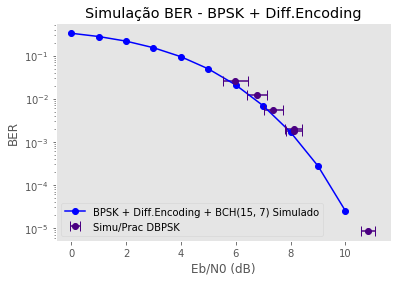

In [151]:
plt.style.use('ggplot')
#plt.semilogy(EbN0_range, theory, "g-.", label = "BPSK + Diff.Encoding Teórico")
plt.semilogy(EbN0_range, simu, "b-o", label = "BPSK + Diff.Encoding + BCH(15, 7) Simulado")
plt.errorbar(np.array(snr_avgs) + 10*math.log10(15/7), bers, xerr = snr_stds, fmt = "o", color = "indigo", capsize = 5, label = "Simu/Prac DBPSK")
plt.legend()
plt.grid()

plt.title('Simulação BER - BPSK + Diff.Encoding')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.savefig("Curva.png")